# Financial Turbulance

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.dates as mdates


In [154]:
# Load momemtum data from the momentum.csv file
data_momentum = pd.read_csv('momentum.csv', index_col=0)
data_momentum.index = data_momentum.index.astype(int)
# last daily momemdata from /Users/anderssteiness/Desktop/MIT/CapMar/F-F_Momentum_Factor_daily.CSV 
data_momentum_daily = pd.read_csv('F-F_Momentum_Factor_daily.CSV', index_col=0)[:-1]
#Make date format for data_momentum_daily index change from YYYYMMDD to YYYY-MM-DD
data_momentum_daily.index = pd.to_datetime(data_momentum_daily.index, format='%Y%m%d')

In [151]:
#print(data_momentum[:200800].mean())
#print(data_momentum[200800:])
#slice data_momentum into prior 200800 and after 200800
print(data_momentum[data_momentum.index <= 200810].mean())
print(data_momentum[data_momentum.index > 200810].mean())

Mom    0.772138
dtype: float64
Mom   -0.177542
dtype: float64


In [65]:
data_momentum_pct = data_momentum/100 + 1
data_momentum_pct

,Mom
Date,
192701,1.0036
192702,0.9786
192703,1.0361
192704,1.0430
192705,1.0300
...,...
202305,0.9937
202306,0.9763
202307,0.9602


<Axes: xlabel='Date'>

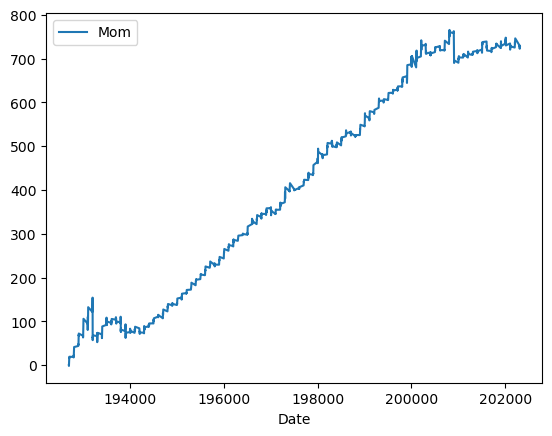

In [69]:
data_momentum.cumsum().plot()

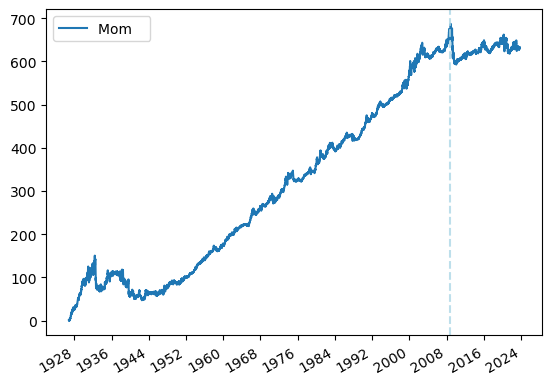

In [169]:
fig, ax = plt.subplots()
data_momentum_daily.cumsum().plot(ax=ax)
# Set major ticks format
ax.xaxis.set_major_locator(mdates.YearLocator(base=8))  # to get a tick every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format the ticks to display only the year
ax.axvline(pd.Timestamp('2008-09-29'), color='lightblue', linestyle='--', alpha= 0.8)
plt.show()


In [7]:
# Proxy tickers for the asset classes
tickers = {
    "US_Stocks": "SPY",  # S&P 500 ETF
#    "Non_US_Stocks": "VEU",  # Vanguard FTSE All-World ex-US ETF
    "US_Bonds": "BND",  # Vanguard Total Bond Market ETF
#    "Non_US_Bonds": "BNDX",  # Vanguard Total International Bond ETF
#    "Commodities": "DBC",  # Invesco DB Commodity Index Tracking Fund
#    "US_Real_Estate": "VNQ"  # Vanguard Real Estate ETF
}

# Function to download monthly return data
def download_monthly_returns(tickers):
    monthly_returns = {}
    for name, ticker in tickers.items():
        data = yf.download(ticker, start="1990-01-01", end="2023-10-31", progress=False)
        data.index = pd.to_datetime(data.index)  # Ensure the index is a DateTimeIndex
        monthly_data = data['Adj Close'].resample('M').last()
        monthly_returns[name] = monthly_data.pct_change().dropna()
    return pd.DataFrame(monthly_returns)

# Fetch the data
monthly_returns = download_monthly_returns(tickers)
monthly_returns = monthly_returns * 12 # Convert to percentages

print(monthly_returns.head())  # Display the last few rows of the data

            US_Stocks  US_Bonds
Date                           
1993-02-28   0.128022       NaN
1993-03-31   0.268794       NaN
1993-04-30  -0.307050       NaN
1993-05-31   0.323631       NaN
1993-06-30   0.043289       NaN


In [8]:
monthly_returns.dropna().corr()
#check if singular

,US_Stocks,US_Bonds
US_Stocks,1.000000,0.224539
US_Bonds,0.224539,1.000000


In [88]:
# Computing financial tubulance
financial_turbulence_series = pd.Series(index=monthly_returns.index, dtype=float)

# Function to calculate Mahalanobis distance
def calculate_mahalanobis_distance(returns, mu, Sigma):
    #Raise an exception if the covariance matrix is not singular
    if np.linalg.det(Sigma) == 0.0:
        print(Sigma)

    inv_Sigma = np.linalg.inv(Sigma)
    return ((returns - mu).dot(inv_Sigma).dot((returns - mu).T))

# Iterate through each time period in the DataFrame
for t in range(11, len(monthly_returns)):
    # Use data up to t-1 to calculate mean and covariance, excluding NaN values
    valid_data = monthly_returns.iloc[:t].dropna()
    mu = valid_data.mean()
    Sigma = valid_data.cov()

    # Calculate the Financial Turbulence at time t
    current_return = monthly_returns.iloc[t].dropna()
    if not current_return.empty and not Sigma.empty:  # Check if data is sufficient
        turbulence_at_t = calculate_mahalanobis_distance(current_return, mu, Sigma)
        financial_turbulence_series.iloc[t] = turbulence_at_t

# The financial_turbulence_series now contains the Financial Turbulence Index for each time period
print(financial_turbulence_series)

/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packa

           US_Stocks  US_Bonds
US_Stocks    0.16965 -0.016620
US_Bonds    -0.01662  0.001628


/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


LinAlgError: Singular matrix

In [29]:
monthly_returns

,US_Stocks,Non_US_Stocks,US_Bonds,Non_US_Bonds,Commodities,US_Real_Estate,turbulence
Date,,,,,,,
1993-02-28,0.010669,NaN,NaN,NaN,NaN,NaN,NaN
1993-03-31,0.022399,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-30,-0.025588,NaN,NaN,NaN,NaN,NaN,NaN
1993-05-31,0.026969,NaN,NaN,NaN,NaN,NaN,NaN
1993-06-30,0.003607,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-06-30,0.064800,0.045339,-0.002237,0.000061,0.029479,0.056294,NaN
2023-07-31,0.032733,0.037677,-0.001186,-0.001270,0.087225,0.020345,NaN
2023-08-31,-0.016252,-0.043925,-0.006604,0.002096,-0.003647,-0.033779,NaN


# Volatility Index 

In [9]:
# Define the ticker symbol for the VIX index and download data
vix_ticker = '^VIX'
vix_data = yf.download(vix_ticker, start='1990-02-01', end='2023-11-19')
# Display the first few rows of the dataframe
print(vix_data.head())


[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
1990-02-01  24.870001  24.870001  24.870001  24.870001  24.870001       0
1990-02-02  24.320000  24.320000  24.320000  24.320000  24.320000       0
1990-02-05  24.540001  24.540001  24.540001  24.540001  24.540001       0
1990-02-06  24.690001  24.690001  24.690001  24.690001  24.690001       0
1990-02-07  24.290001  24.290001  24.290001  24.290001  24.290001       0


In [10]:
# Generate montly averages of the VIX index
monthly_vix = vix_data['Adj Close'].resample('M').mean()
# Change the monthly_vix index to have the form YYYYMM
monthly_vix.index = monthly_vix.index.map(lambda x: 100*x.year + x.month)
# Join the VIX data to the monthly data_momentum DataFrame inner so that only months with both data are included 
data_momentum_vix = data_momentum.join(monthly_vix, how='inner')

In [28]:
# Conduct a linear regression of the VIX index on the momentum index
import statsmodels.api as sm
X = data_momentum_vix['Adj Close']
X = sm.add_constant(X)
y = data_momentum_vix['Mom']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Mom   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6582
Date:                Sun, 19 Nov 2023   Prob (F-statistic):              0.418
Time:                        18:46:50   Log-Likelihood:                -1199.6
No. Observations:                 404   AIC:                             2403.
Df Residuals:                     402   BIC:                             2411.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9420      0.653      1.442      0.1

                Mom  Adj Close
Mom        1.000000  -0.040429
Adj Close -0.040429   1.000000


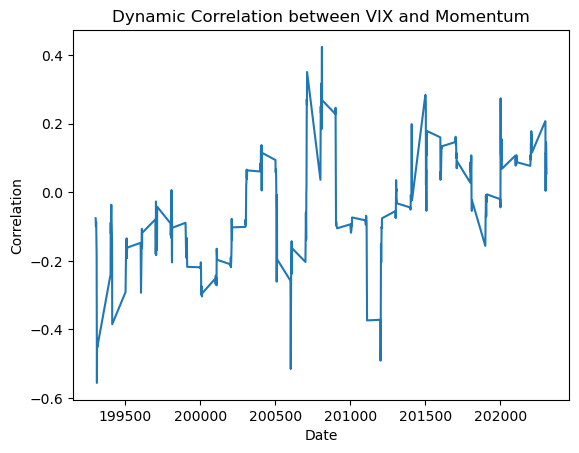

In [67]:
# Compute the correlation between the VIX index and the momentum index
print(data_momentum_vix.corr())

# Compute the dynamic correlation between the VIX index and the momentum index
dynamic_correlation = data_momentum_vix['Mom'].rolling(36).corr(data_momentum_vix['Adj Close'])
plt.plot(dynamic_correlation)
plt.title('Dynamic Correlation between VIX and Momentum')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()


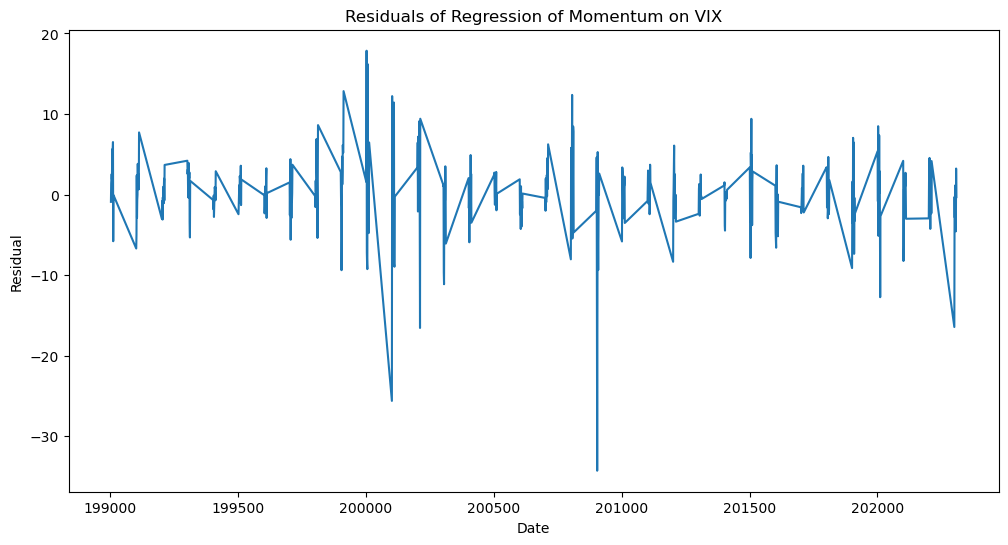

In [29]:
# Plot the residuals of the regression
plt.figure(figsize=(12, 6))
plt.plot(results.resid)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals of Regression of Momentum on VIX')
plt.show()


MSE: 25.130


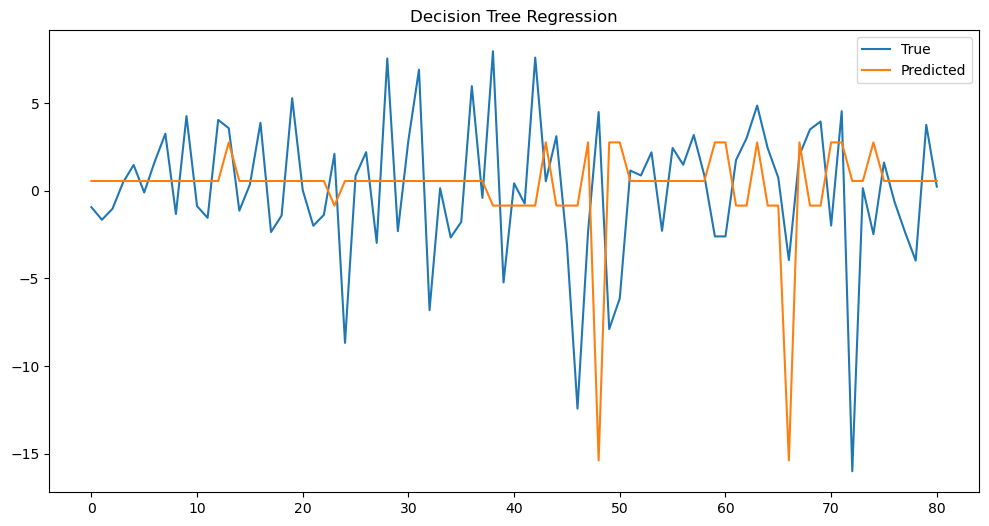

In [45]:
# Fit a decision tree regressor to the data
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Split the data into training and test sets
X = data_momentum_vix['Adj Close'].values.reshape(-1, 1)
y = data_momentum_vix['Mom'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the decision tree regressor
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree.predict(X_test)

# Compute the MSE
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Decision Tree Regression')
plt.show()


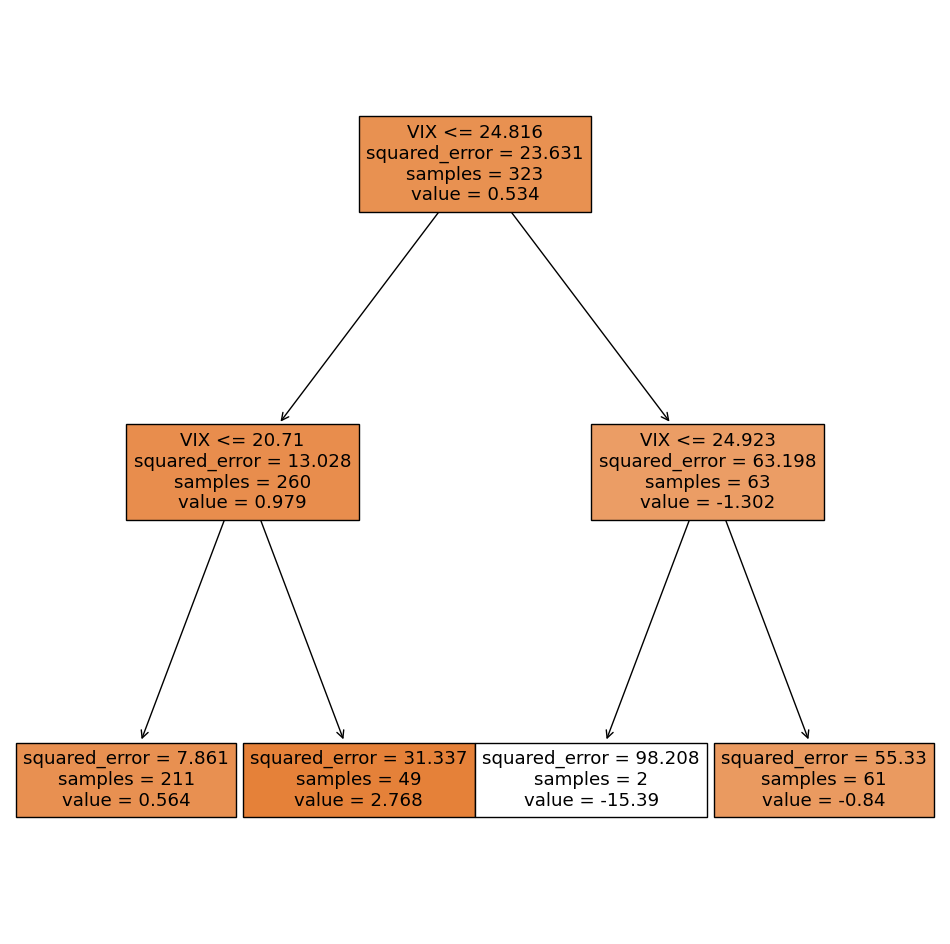

In [41]:
# Show the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 12))
plot_tree(tree, feature_names=['VIX'], filled=True)
plt.show()

/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 18.874


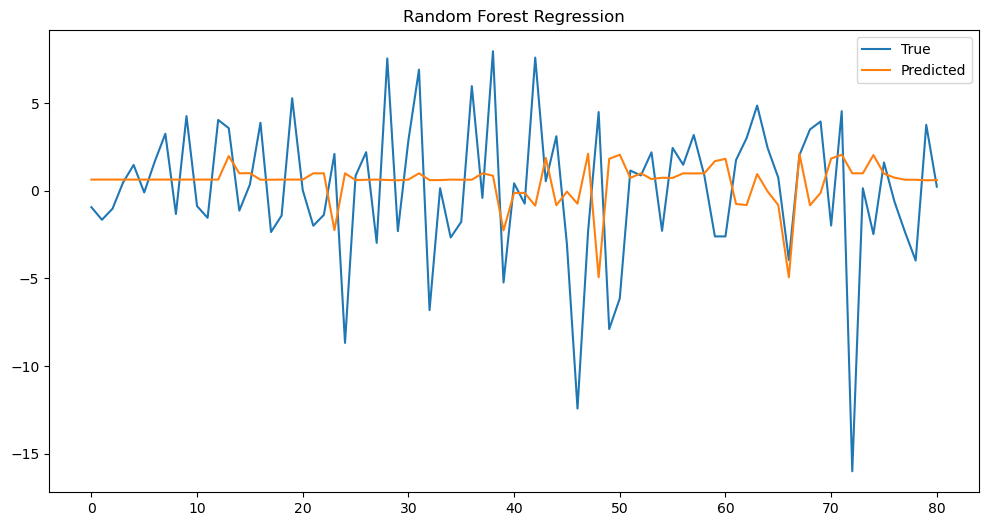

In [52]:
# Fit a random forest regressor to the data
from sklearn.ensemble import RandomForestRegressor

# Fit the random forest regressor
forest = RandomForestRegressor(n_estimators=300, max_depth=2)
forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = forest.predict(X_test)

# Compute the MSE
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Random Forest Regression')
plt.show()


/Users/anderssteiness/opt/anaconda3/envs/DaML/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 29.294


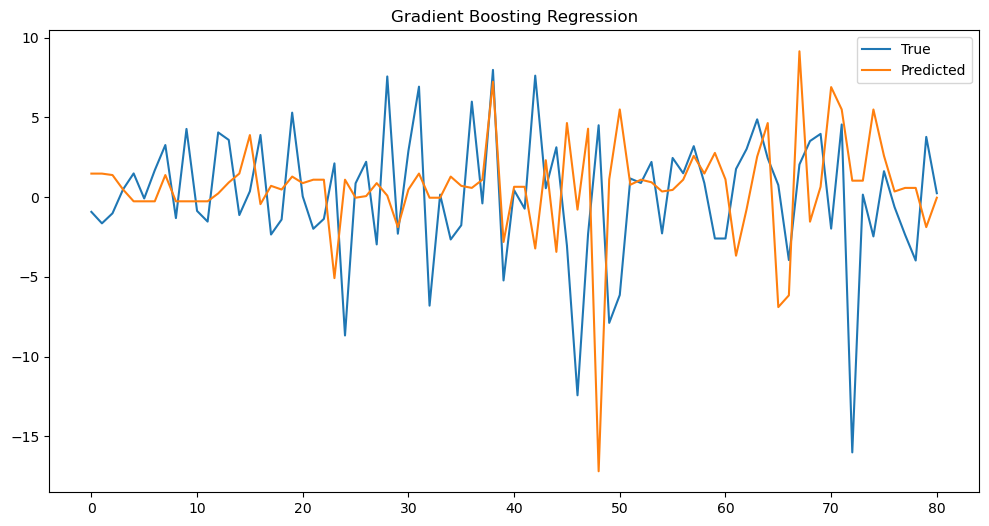

In [55]:
# Fit a gradient boosting regressor to the data
from sklearn.ensemble import GradientBoostingRegressor

# Fit the gradient boosting regressor
gb = GradientBoostingRegressor(n_estimators=300, max_depth=2)
gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb.predict(X_test)

# Compute the MSE
mse = mean_squared_error(y_test, y_pred)

print('MSE: %.3f' % mse)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Gradient Boosting Regression')
plt.show()


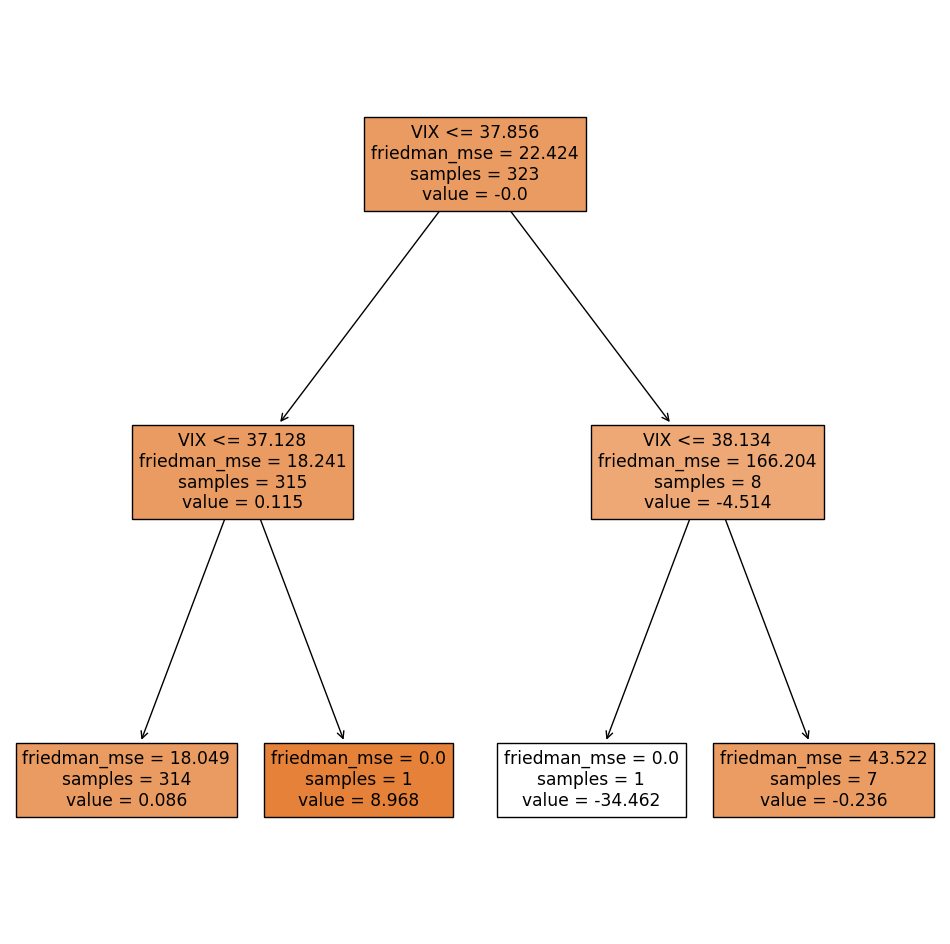

In [63]:
# Find the splits that provided the most information gain from gradient boosting
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 12))
plot_tree(gb.estimators_[3, 0], feature_names=['VIX'], filled=True)
plt.show()


# T Tests

In [71]:
# Load momemtum data from the momentum.csv file
data_momentum = pd.read_csv('momentum.csv', index_col=0)
data_momentum.index = data_momentum.index.astype(int)

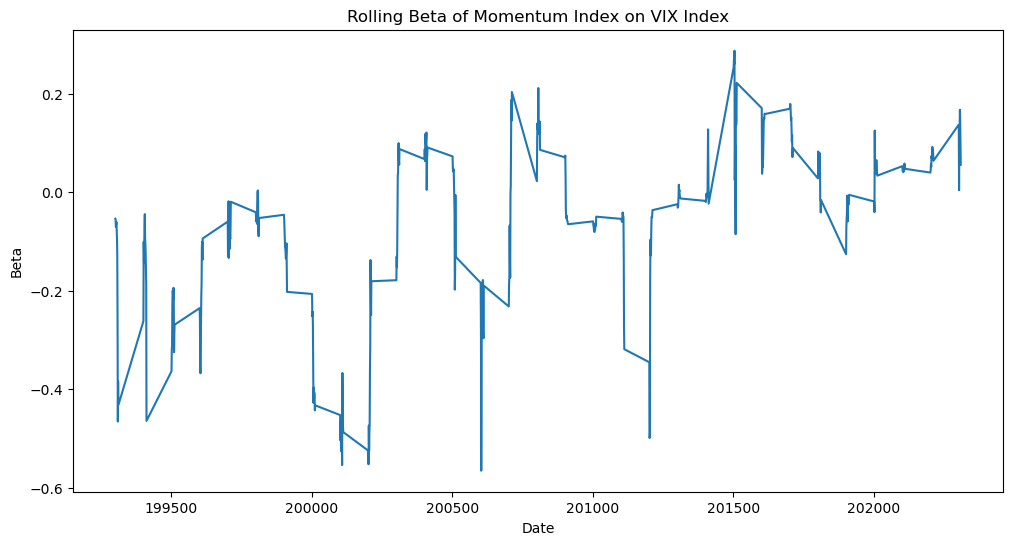

In [12]:
# Perform a rolling linear regression of the momentum index on the VIX index
rolling_window = 36
rolling_beta = data_momentum_vix['Mom'].rolling(rolling_window).cov(data_momentum_vix['Adj Close']) / data_momentum_vix['Adj Close'].rolling(rolling_window).var()

# Plot the rolling beta
plt.figure(figsize=(12, 6))
plt.plot(rolling_beta)
plt.title('Rolling Beta of Momentum Index on VIX Index')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.show()

In [13]:
# Conduct t test of returns before and after 2008
from scipy.stats import ttest_ind
before_2008 = data_momentum[data_momentum.index <= 200800]['Mom']
after_2008 = data_momentum[data_momentum.index > 200800]['Mom']
t, p = ttest_ind(before_2008, after_2008)
print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)

t statistic: 2.246
p-value: 0.025


## 6 Portfolios

In [184]:
import yfinance as yf
import pandas as pd
import datetime

def calculate_bear_market_indicator(data, threshold=0.20):
    """
    Calculate the bear market indicator.
    A value of 1 indicates a bear market, 0 otherwise.
    
    :param data: DataFrame with market data.
    :param threshold: Percentage drop to define a bear market.
    :return: Series with bear market indicator.
    """
    # Calculate the rolling maximum
    rolling_max = data['Close'].rolling(window=12, min_periods=1).max()
    # Calculate drawdown from the rolling maximum
    drawdown = (data['Close'] - rolling_max) / rolling_max
    # Bear market indicator (1 if drawdown <= -20%, 0 otherwise)
    bear_market_indicator = (drawdown <= -threshold).astype(int)
    return bear_market_indicator

# Fetch S&P 500 index data using yfinance, monthly returns
sp500 = yf.download('^GSPC', start='1990-01-01', end=datetime.datetime.now().strftime('%Y-%m-%d'))
#sp500 = sp500['Adj Close'].resample('M').last().pct_change().dropna()

# Calculate the bear market indicator
sp500['Bear_Market_Indicator'] = calculate_bear_market_indicator(sp500)
# Calculate the market variance (placeholder for your actual calculation)
market_variance = sp500['Close'].rolling(window=126).var()

# Load your WML portfolio data
#momentum_portfolio = pd.read_csv('10_Portfolios_Prior_12_2_Daily.CSV', skiprows=9, index_col=0, parse_dates=True, header=0)
momentum_portfolio = pd.read_csv('/Users/anderssteiness/Desktop/MIT/CapMar/data/6_Portfolios_Daily.CSV', skiprows=1, index_col=0, parse_dates=True, header=0)
# Put the momentum portfolio date format from YYYYMMDD to YYYY-MM-DD
momentum_portfolio.dtypes
# Make index to type int and then type datetime
numeric_indices = pd.to_numeric(momentum_portfolio.index, errors='coerce').notna()
momentum_portfolio = momentum_portfolio[numeric_indices]
momentum_portfolio.index = momentum_portfolio.index.astype(int)
# Put the momentum portfolio date format from YYYYMMDD to YYYY-MM-DD
momentum_portfolio.index = pd.to_datetime(momentum_portfolio.index, format='%Y%m%d')
#MAke all columns float momentum_portfolio except Index
momentum_portfolio = momentum_portfolio.astype(float)

# Ensire momentum_portfolio uses same time period as market_variance
#momentum_portfolio = momentum_portfolio[momentum_portfolio.index >= market_variance.index[0]]
#momentum_portfolio = momentum_portfolio[momentum_portfolio.index <= market_variance.index[-1]]


# The 'Bear_Market_Indicator' column now contains the bear market indicator
print(sp500[['Close', 'Bear_Market_Indicator']])

[*********************100%%**********************]  1 of 1 completed
                  Close  Bear_Market_Indicator
Date                                          
1990-01-02   359.690002                      0
1990-01-03   358.760010                      0
1990-01-04   355.670013                      0
1990-01-05   352.200012                      0
1990-01-08   353.790009                      0
...                 ...                    ...
2023-11-16  4508.240234                      0
2023-11-17  4514.020020                      0
2023-11-20  4547.379883                      0
2023-11-21  4538.189941                      0
2023-11-22  4556.620117                      0

[8540 rows x 2 columns]


In [199]:
# Download the daily returns of the momentum portfolio
sp500['Adj Close'].resample('M').last().pct_change().dropna()

Date
1990-02-28    0.008539
1990-03-31    0.024255
1990-04-30   -0.026887
1990-05-31    0.091989
1990-06-30   -0.008886
                ...   
2023-07-31    0.031139
2023-08-31   -0.017716
2023-09-30   -0.048719
2023-10-31   -0.021980
2023-11-30    0.086514
Freq: M, Name: Adj Close, Length: 406, dtype: float64

In [179]:
# Regression model
X = pd.concat([sp500['Bear_Market_Indicator'], market_variance, sp500['Bear_Market_Indicator'] * market_variance], axis=1)
y = momentum_portfolio['returns']  # Replace with your portfolio returns column
X = sm.add_constant(X)  # Adding a constant

model = sm.OLS(y, X).fit()
print(model.summary())




KeyError: 'returns'

In [186]:
( 1/2 * (momentum_portfolio[momentum_portfolio.index > '2008-10-01']['BIG HiPRIOR'] + momentum_portfolio[momentum_portfolio.index > '2008-10-01']['SMALL HiPRIOR'])).mean()

0.053732114467408575

In [200]:
# Quick statistical t test of the Hi Priori portfolio portfolio return before and after 2008
from scipy.stats import ttest_ind
before_2008 = 1/2 * (momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['BIG HiPRIOR'] + momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['SMALL HiPRIOR'])
after_2008 = 1/2 * (momentum_portfolio[momentum_portfolio.index > '2008-10-01']['BIG HiPRIOR'] + momentum_portfolio[momentum_portfolio.index > '2008-10-01']['SMALL HiPRIOR'])
t, p = ttest_ind(before_2008, after_2008)
print('High return portfolio')
print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)
#mean of Hi Priori portfolio before 2008 and after 2008

print('\n')

# Quick statistical t test of the Lo Priori portfolio return before and after 2008
before_2008 = 1/2 * (momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['SMALL LoPRIOR'] + momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['BIG LoPRIOR'])
after_2008 = 1/2 * (momentum_portfolio[momentum_portfolio.index > '2008-10-01']['SMALL LoPRIOR'] + momentum_portfolio[momentum_portfolio.index > '2008-10-01']['BIG LoPRIOR'])
t, p = ttest_ind(before_2008, after_2008)
print('Low return portfolio')
print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)


High return portfolio
t statistic: 0.619
p-value: 0.536


Low return portfolio
t statistic: -0.955
p-value: 0.340


Individual portfolios:

In [201]:
before_2008 = (momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['BIG HiPRIOR'])
after_2008 = (momentum_portfolio[momentum_portfolio.index > '2008-10-01']['BIG HiPRIOR'])
t, p = ttest_ind(before_2008, after_2008)
print('Big High return portfolio')
print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)

Big High return portfolio
t statistic: 0.088
p-value: 0.930


In [202]:
before_2008 = (momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['SMALL HiPRIOR'])
after_2008 = (momentum_portfolio[momentum_portfolio.index > '2008-10-01']['SMALL HiPRIOR'])
t, p = ttest_ind(before_2008, after_2008)
print('Small High return portfolio')
print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)

Small High return portfolio
t statistic: 1.067
p-value: 0.286


In [203]:
before_2008 = (momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['BIG LoPRIOR'])
after_2008 = (momentum_portfolio[momentum_portfolio.index > '2008-10-01']['BIG LoPRIOR'])
t, p = ttest_ind(before_2008, after_2008)
print('Big Low return portfolio')
print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)

Big Low return portfolio
t statistic: -1.428
p-value: 0.153


In [204]:
before_2008 = (momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['SMALL LoPRIOR'])
after_2008 = (momentum_portfolio[momentum_portfolio.index > '2008-10-01']['SMALL LoPRIOR'])
t, p = ttest_ind(before_2008, after_2008)
print('Small High return portfolio')
print('t Low: %.3f' % t)
print('p-value: %.3f' % p)

Small High return portfolio
t Low: -0.406
p-value: 0.685


In [198]:
print(momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['BIG HiPRIOR'].mean())
print(momentum_portfolio[momentum_portfolio.index > '2008-10-01']['BIG HiPRIOR'].mean())
print("\n")
print(momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['SMALL HiPRIOR'].mean())
print(momentum_portfolio[momentum_portfolio.index > '2008-10-01']['SMALL HiPRIOR'].mean())
print("\n")
print(momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['BIG LoPRIOR'].mean())
print(momentum_portfolio[momentum_portfolio.index > '2008-10-01']['BIG LoPRIOR'].mean())
print("\n")
print(momentum_portfolio[momentum_portfolio.index <= '2008-10-01']['SMALL LoPRIOR'].mean())
print(momentum_portfolio[momentum_portfolio.index > '2008-10-01']['SMALL LoPRIOR'].mean())


0.052325088664732164
0.050474297827239


0.08114688406798398
0.05698993110757816


0.026571783888351526
0.062175410704822465


0.046590668324812304
0.056664016958134604


In [205]:
mom_strat_returns =  1/2 * (momentum_portfolio['SMALL HiPRIOR'] + momentum_portfolio['BIG HiPRIOR']) - 1/2 * (momentum_portfolio['SMALL LoPRIOR'] + momentum_portfolio['BIG LoPRIOR'])
before_2008 = mom_strat_returns[mom_strat_returns.index <= '2008-01-01']
after_2008 = mom_strat_returns[mom_strat_returns.index > '2008-01-01']
t, p = ttest_ind(before_2008, after_2008)
print('Big High return portfolio')
print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)

Big High return portfolio
t statistic: 2.478
p-value: 0.013


In [190]:
# I want to scroll through the momentum portfolio momentum_portfolio['SMALL HiPRIOR']
momentum_portfolio['SMALL HiPRIOR'].cumsum() 

# check if any days are counted twice
momentum_portfolio['SMALL HiPRIOR'].index.value_counts()

1926-11-03    1
1990-01-23    1
1990-01-19    1
1990-01-18    1
1990-01-17    1
             ..
1956-03-29    1
1956-03-28    1
1956-03-27    1
1956-03-26    1
2023-09-29    1
Name: count, Length: 25485, dtype: int64

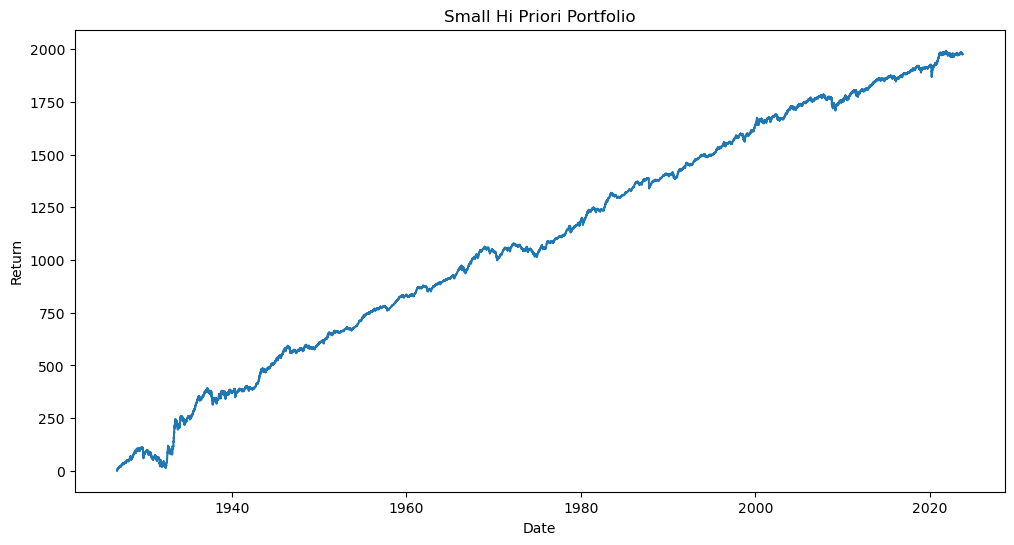

In [191]:
# Plot momentum_portfolio['SMALL HiPRIOR'] 
plt.figure(figsize=(12, 6))
plt.plot(momentum_portfolio['SMALL HiPRIOR'].cumsum())
plt.title('Small Hi Priori Portfolio')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()




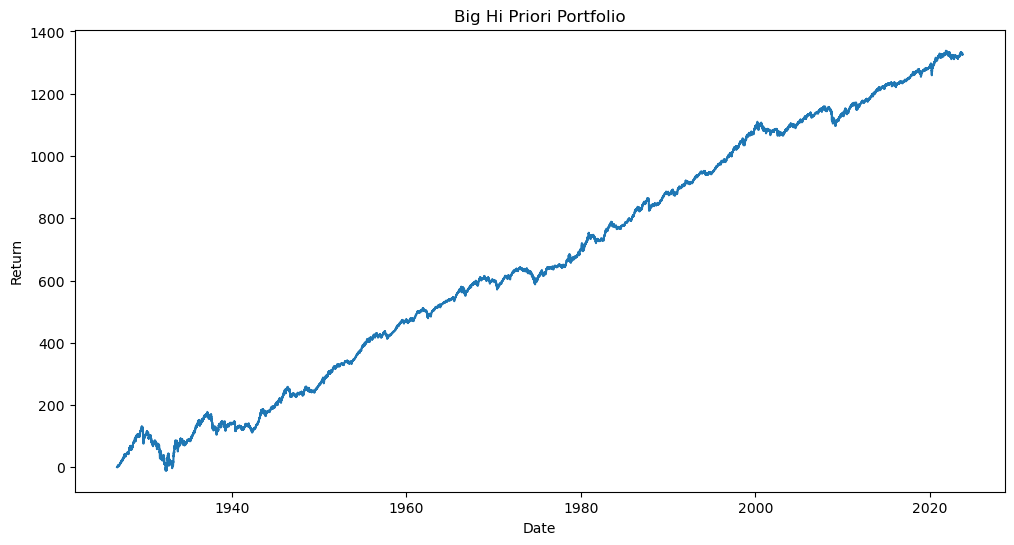

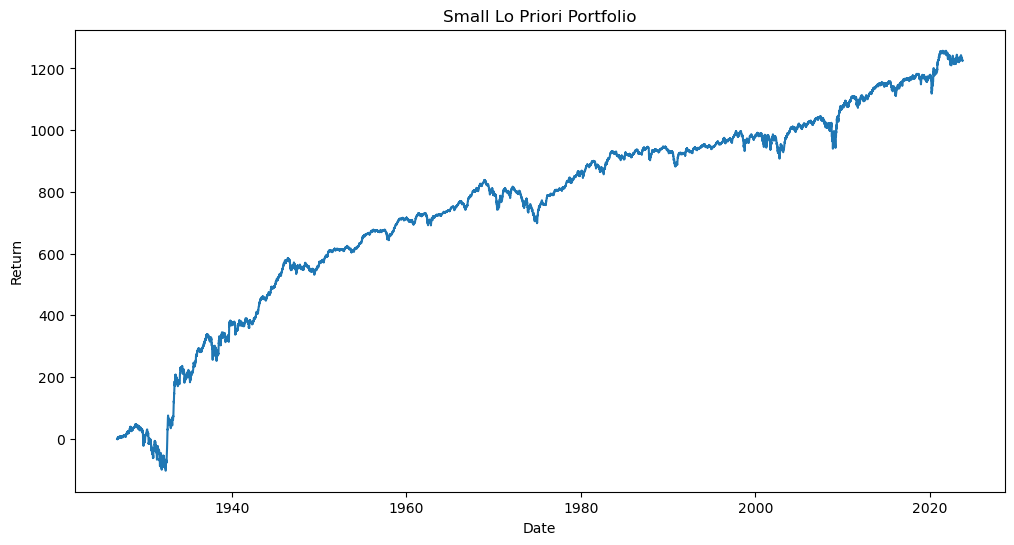

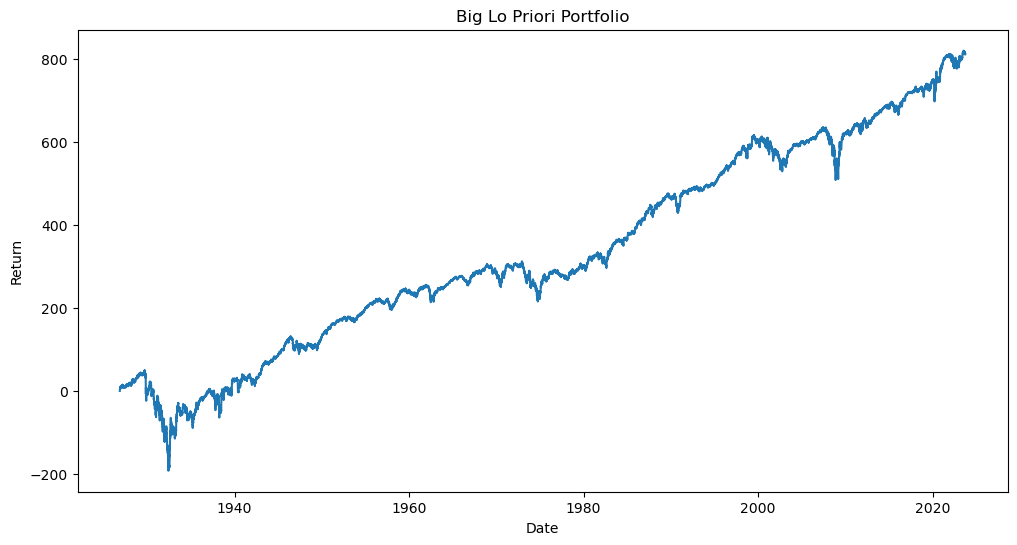

In [192]:
# Plot momentum_portfolio['BIG HiPRIOR']
plt.figure(figsize=(12, 6))
plt.plot(momentum_portfolio['BIG HiPRIOR'].cumsum())
plt.title('Big Hi Priori Portfolio')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

# Plot momentum_portfolio['SMALL LoPRIOR']
plt.figure(figsize=(12, 6))
plt.plot(momentum_portfolio['SMALL LoPRIOR'].cumsum())
plt.title('Small Lo Priori Portfolio')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

# Plot momentum_portfolio['BIG LoPRIOR']
plt.figure(figsize=(12, 6))
plt.plot(momentum_portfolio['BIG LoPRIOR'].cumsum())
plt.title('Big Lo Priori Portfolio')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

In [170]:
# Getting monthly returns
#mom_strat_returns_M = mom_strat_returns.resample('M').last().pct_change().dropna()
mom_strat_returns.cumsum()

1926-11-03      0.555
1926-11-04      0.050
1926-11-05      1.220
1926-11-06      1.195
1926-11-08      1.185
               ...   
2023-09-25    787.610
2023-09-26    787.945
2023-09-27    789.030
2023-09-28    789.690
2023-09-29    788.675
Length: 50970, dtype: float64

In [142]:
# Check for nans in mom_strat_returns_M

False

In [108]:
# Conduct t test of returns before and after 2008
from scipy.stats import ttest_ind
before_2008 = data_momentum[data_momentum.index <= 200810]['Mom']
after_2008 = data_momentum[data_momentum.index > 200810]['Mom']
t, p = ttest_ind(before_2008, after_2008)
print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)

t statistic: 2.490
p-value: 0.013


In [45]:
# The 'Bear_Market_Indicator' column now contains the bear market indicator

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
1926-11-03,-0.12,0.60,-0.09,0.30,-0.51,-0.22,-0.12,0.50,0.13,1.28
1926-11-04,0.65,1.82,1.34,0.61,1.01,0.64,0.82,0.44,0.48,0.40
1926-11-05,-0.84,-0.77,-0.22,-0.15,-0.02,-0.02,-0.07,0.36,0.20,0.08
1926-11-06,1.03,0.28,0.24,0.40,0.19,0.64,0.10,0.10,0.39,-0.68
1926-11-08,-0.06,0.11,1.78,0.28,0.36,0.23,0.30,1.17,0.58,-0.18
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.80,-0.16,0.00,0.13,-0.15,0.31,0.08,0.29,0.39,0.26
2023-09-26,0.10,-0.94,-0.96,-0.79,-1.15,-1.06,-0.90,-1.18,-1.18,1.24
2023-09-27,-0.16,0.10,0.16,0.05,0.26,0.80,0.69,0.86,1.09,1.19
2023-09-28,0.03,0.44,0.28,0.64,0.55,0.43,0.89,1.09,0.74,1.10


In [ ]:
# Regression model
X = pd.concat([bear_market_indicator, market_variance, bear_market_indicator * market_variance], axis=1)
y = momentum_portfolio['returns']  # Replace with your portfolio returns column
X = sm.add_constant(X)  # Adding a constant

model = sm.OLS(y, X).fit()
print(model.summary())

## 10 Portfolios

In [110]:
momentum_portfolio_10

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
19261103,-0.12,0.60,-0.09,0.30,-0.51,-0.22,-0.12,0.50,0.13,1.28
19261104,0.65,1.82,1.34,0.61,1.01,0.64,0.82,0.44,0.48,0.40
19261105,-0.84,-0.77,-0.22,-0.15,-0.02,-0.02,-0.07,0.36,0.20,0.08
19261106,1.03,0.28,0.24,0.40,0.19,0.64,0.10,0.10,0.39,-0.68
19261108,-0.06,0.11,1.78,0.28,0.36,0.23,0.30,1.17,0.58,-0.18
...,...,...,...,...,...,...,...,...,...,...
20230925,-0.80,-0.16,0.00,0.13,-0.15,0.31,0.08,0.29,0.39,0.26
20230926,0.10,-0.94,-0.96,-0.79,-1.15,-1.06,-0.90,-1.18,-1.18,1.24
20230927,-0.16,0.10,0.16,0.05,0.26,0.80,0.69,0.86,1.09,1.19
20230928,0.03,0.44,0.28,0.64,0.55,0.43,0.89,1.09,0.74,1.10


In [113]:
# Load your WML portfolio data
momentum_portfolio_10 = pd.read_csv('10_Portfolios_Prior_12_2_Daily.CSV', skiprows=9, index_col=0, parse_dates=True, header=0)
# Put the momentum portfolio date format from YYYYMMDD to YYYY-MM-DD
momentum_portfolio_10.dtypes
# Make index to type int and then type datetime
numeric_indices = pd.to_numeric(momentum_portfolio_10.index, errors='coerce').notna()
momentum_portfolio_10 = momentum_portfolio_10[numeric_indices]
momentum_portfolio_10.index = momentum_portfolio_10.index.astype(int)
# Put the momentum portfolio date format from YYYYMMDD to YYYY-MM-DD
momentum_portfolio_10.index = pd.to_datetime(momentum_portfolio_10.index, format='%Y%m%d')
#MAke all columns float momentum_portfolio except Index
momentum_portfolio_10 = momentum_portfolio_10.astype(float)
momentum_portfolio_10

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
1926-11-03,-0.12,0.60,-0.09,0.30,-0.51,-0.22,-0.12,0.50,0.13,1.28
1926-11-04,0.65,1.82,1.34,0.61,1.01,0.64,0.82,0.44,0.48,0.40
1926-11-05,-0.84,-0.77,-0.22,-0.15,-0.02,-0.02,-0.07,0.36,0.20,0.08
1926-11-06,1.03,0.28,0.24,0.40,0.19,0.64,0.10,0.10,0.39,-0.68
1926-11-08,-0.06,0.11,1.78,0.28,0.36,0.23,0.30,1.17,0.58,-0.18
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.80,-0.16,0.00,0.13,-0.15,0.31,0.08,0.29,0.39,0.26
2023-09-26,0.10,-0.94,-0.96,-0.79,-1.15,-1.06,-0.90,-1.18,-1.18,1.24
2023-09-27,-0.16,0.10,0.16,0.05,0.26,0.80,0.69,0.86,1.09,1.19
2023-09-28,0.03,0.44,0.28,0.64,0.55,0.43,0.89,1.09,0.74,1.10


In [ ]:
momentum_portfolio_10.as

# VIX PLOT AGAINST MOVING AVERAGE

In [351]:
# GETTING DAILY MOMENTUM AND VIX INDEX DATA
data_momentum_daily = pd.read_csv('F-F_Momentum_Factor_daily.CSV', index_col=0)[:-1]
#Make date format for data_momentum_daily index change from YYYYMMDD to YYYY-MM-DD
data_momentum_daily.index = pd.to_datetime(data_momentum_daily.index, format='%Y%m%d')

# Define the ticker symbol for the VIX index and download data
vix_ticker = '^VIX'
vix_data = yf.download(vix_ticker, start='1995-02-01', end='2023-10-31')
# Display the first few rows of the dataframe
# Generate montly averages of the VIX index
monthly_vix = vix_data['Adj Close']
# Make monthly_vix index to type dateframe pandas 
monthly_vix = monthly_vix.to_frame()
# Join the VIX data to the monthly data_momentum DataFrame inner so that only months with both data are included 
data_momentum_vix = data_momentum_daily.join(monthly_vix, how='inner')
# Change column name from Adj Close to VIX
data_momentum_vix = data_momentum_vix.rename(columns={'Adj Close': 'VIX'})
data_momentum_vix = data_momentum_vix.rename(columns={'Mom   ': 'Mom'})
data_momentum_vix['VIX'] = data_momentum_vix['VIX'].dropna()
data_momentum_vix = data_momentum_vix.dropna()

[*********************100%%**********************]  1 of 1 completed


In [353]:
data_momentum_vix

,Mom,VIX
1995-02-01,-0.34,11.730000
1995-02-02,0.01,11.130000
1995-02-03,0.04,10.980000
1995-02-06,-0.05,11.220000
1995-02-07,-0.01,11.170000
...,...,...
2023-09-25,0.13,16.900000
2023-09-26,0.39,18.940001
2023-09-27,1.16,18.219999
2023-09-28,0.27,17.340000


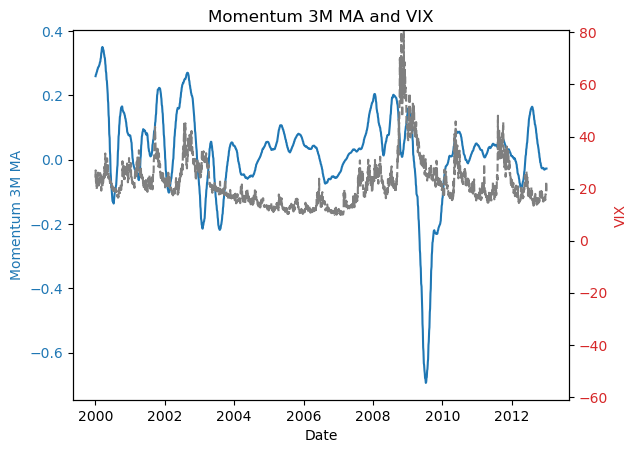

In [362]:
# Compute the 3 months moving average return of the momentum index, and the VIX index and plot the results, with different scales on the same plot
data_momentum_vix['Mom_3M_MA'] = data_momentum_vix['Mom'].rolling(window=63).mean()
data_filtered = data_momentum_vix['2000':'2012']
# Find the range for Momentum 3M MA
mom_range = data_filtered['Mom_3M_MA'].max() - data_filtered['Mom_3M_MA'].min()
# Find the range for VIX
vix_range = data_filtered['VIX'].max() - data_filtered['VIX'].min()
# Determine the ratio of the two ranges
ratio = mom_range / vix_range

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Momentum 3M MA', color='tab:blue')
ax1.plot(data_filtered.index, data_filtered['Mom_3M_MA'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('VIX', color='tab:red')
ax2.plot(data_filtered.index, data_filtered['VIX'], color='tab:grey', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax2.set_ylim([data_filtered['VIX'].min() - (mom_range / ratio), data_filtered['VIX'].max()])


plt.title('Momentum 3M MA and VIX')
plt.show()

,Mom
1926-11-03,0.56
1926-11-04,-0.50
1926-11-05,1.17
1926-11-06,-0.03
1926-11-08,-0.01
...,...
2023-09-25,0.13
2023-09-26,0.39
2023-09-27,1.16
2023-09-28,0.27


# Market States and Momentum - Michael J. Cooper

In [ ]:
# Load momemtum data from the momentum.csv file
data_momentum = pd.read_csv('momentum.csv', index_col=0)
data_momentum.index = data_momentum.index.astype(int)
# last daily momemdata from /Users/anderssteiness/Desktop/MIT/CapMar/F-F_Momentum_Factor_daily.CSV 
data_momentum_daily = pd.read_csv('F-F_Momentum_Factor_daily.CSV', index_col=0)[:-1]
#Make date format for data_momentum_daily index change from YYYYMMDD to YYYY-MM-DD
data_momentum_daily.index = pd.to_datetime(data_momentum_daily.index, format='%Y%m%d')

In [308]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.api as sm

# Define the function to download and process monthly S&P 500 data
def download_sp500_monthly_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
    # Adjust for month-end data
    sp500_monthly = sp500['Adj Close'].resample('M').last()
    return sp500_monthly

# Function to define market states based on lagged three-year monthly returns
def define_market_states(sp500_data):
    market_states = {}
    for date in sp500_data.index:
        three_years_ago = date - pd.DateOffset(years=3)
        if three_years_ago in sp500_data.index:
            past_return = sp500_data[date] / sp500_data[three_years_ago] - 1
            market_states[date] = 'UP' if past_return >= 0 else 'DOWN'
    return market_states

### Getting factors
factors_data = pd.read_csv('/Users/anderssteiness/Desktop/MIT/CapMar/F-F_Research_Data_Factors.CSV', skiprows=3)
factors_data['Unnamed: 0'] = pd.to_datetime(factors_data['Unnamed: 0'], format= '%Y%m') #Date 
factors_data['YearMonth'] = factors_data['Unnamed: 0'].dt.to_period('M')
factors_data.set_index('YearMonth', inplace=True)
factors_data.drop('Unnamed: 0', axis=1, inplace=True)#drop 'Unaamed: 0' column

def compute_risk_adjusted_returns(returns, factors_data):
    # Calculate excess returns
    # Align the momentum and factors data to ensure they have the same index
    aligned_momentum, aligned_factors = momentum_returns.align(factors_data, join='inner', axis=0)

    # Now both DataFrames have the same YearMonth index
    # Calculate excess returns for the aligned momentum returns
    aligned_momentum['Excess_Return'] = aligned_momentum['Mom'] 

    # Prepare the factors with a constant term
    X = aligned_factors[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    # The dependent variable is the excess returns of the aligned momentum returns
    Y = aligned_momentum['Excess_Return']

    # Run the regression to get factor loadings
    model = sm.OLS(Y, X).fit()

    # The risk-adjusted return is the residual from the regression
    aligned_momentum['Risk_Adjusted_Return'] = model.resid

    return aligned_momentum['Risk_Adjusted_Return']

# Analyze Momentum Strategy Returns
def analyze_momentum_returns(risk_adjusted_returns, market_states):
    # Ensure risk_adjusted_returns is a DataFrame
    if isinstance(risk_adjusted_returns, pd.Series):
        risk_adjusted_returns = risk_adjusted_returns.to_frame(name='Risk_Adjusted_Return')
    
    # Ensure market_states is a DataFrame
    if isinstance(market_states, pd.Series):
        market_states = market_states.to_frame(name='Market_State')
    
    # If market_states is a dictionary, convert it to a DataFrame
    if isinstance(market_states, dict):
        market_states = pd.DataFrame(list(market_states.items()), columns=['YearMonth', 'Market_State'])
        market_states['YearMonth'] = pd.to_datetime(market_states['YearMonth']).dt.to_period('M')
        market_states.set_index('YearMonth', inplace=True)

    # Combine the data based on index, which in both cases should be YearMonth
    combined_data = risk_adjusted_returns.join(market_states, how='inner')

    # Analysis for UP and DOWN market states
    up_returns = combined_data[combined_data['Market_State'] == 'UP']
    down_returns = combined_data[combined_data['Market_State'] == 'DOWN']

    return up_returns, down_returns, combined_data 


#sp500_monthly_data = download_sp500_monthly_data('1992-01-01', datetime.now()) # Download monthly S&P 500 data
#sp500_monthly_data = download_sp500_monthly_data('1992-01-01', '2008-10-01') #before GFC
sp500_monthly_data = download_sp500_monthly_data('2005-10-01', datetime.now()) #after GFC

market_states = define_market_states(sp500_monthly_data) # Define market states

# Download Momentum Strategy Returns from Ken French's website
# Placeholder for downloading and reading the dataset
momentum_returns = pd.read_csv('momentum.csv')
momentum_returns['Date'] = pd.to_datetime(momentum_returns['Date'], format='%Y%m')
momentum_returns['YearMonth'] = momentum_returns['Date'].dt.to_period('M')
momentum_returns.set_index('Date', inplace=True)
momentum_returns.set_index('YearMonth', inplace=True)
# Risk adjusted momentum returns
risk_adjusted_returns = compute_risk_adjusted_returns(momentum_returns, factors_data)


# Analyze Momentum Strategy Returns
up_returns, down_returns, combined_returns = analyze_momentum_returns(risk_adjusted_returns, market_states)


[*********************100%%**********************]  1 of 1 completed


In [309]:
combined_returns

,Risk_Adjusted_Return,Market_State
YearMonth,,
2008-10,1.845213,DOWN
2008-11,1.466583,DOWN
2008-12,-5.399312,DOWN
2009-01,-10.036413,DOWN
2009-02,-1.941465,DOWN
...,...,...
2023-05,-4.885688,UP
2023-06,-1.888971,UP
2023-07,-2.239430,UP


In [310]:
# Create a dummy variable for UP state
combined_returns['UP_Dummy'] = (combined_returns['Market_State'] == 'UP').astype(int)

# Test if mean profits are equal to zero in each state respectively
# Regression with an intercept
X_with_intercept = sm.add_constant(combined_returns['UP_Dummy'])
model_with_intercept = sm.OLS(combined_returns['Risk_Adjusted_Return'], X_with_intercept).fit()

# Extract the DOWN state mean (intercept) and UP state mean (intercept + coefficient on UP_Dummy)
down_state_mean = model_with_intercept.params['const']
up_state_mean = down_state_mean + model_with_intercept.params['UP_Dummy']
up_state_beta_se = model_with_intercept.bse['UP_Dummy']

# Prepare results
results = {
    'DOWN State Mean Profit': down_state_mean,
    'DOWN State t-statistic': model_with_intercept.tvalues['const'],
    'UP State Mean Profit': up_state_mean, 
    'UP State Beta Standard-Error': up_state_beta_se,
    'UP State t-statistic': model_with_intercept.tvalues['UP_Dummy'],
    'UP State t-statistic': model_with_intercept.tvalues['UP_Dummy'],
    'Difference in Means': model_with_intercept.params['UP_Dummy'],
    'Difference t-statistic': model_with_intercept.tvalues['UP_Dummy']
}

# Print the results
for key, value in results.items():
    print(f"{key}: {value:.4f}")

summary = model_with_intercept.summary()
print(summary)

DOWN State Mean Profit: -2.7678
DOWN State t-statistic: -3.8068
UP State Mean Profit: -0.5518
UP State Beta Standard-Error: 0.8038
UP State t-statistic: 2.7568
Difference in Means: 2.2160
Difference t-statistic: 2.7568
                             OLS Regression Results                             
Dep. Variable:     Risk_Adjusted_Return   R-squared:                       0.042
Model:                              OLS   Adj. R-squared:                  0.036
Method:                   Least Squares   F-statistic:                     7.600
Date:                  Sat, 25 Nov 2023   Prob (F-statistic):            0.00646
Time:                          00:46:49   Log-Likelihood:                -497.62
No. Observations:                   176   AIC:                             999.2
Df Residuals:                       174   BIC:                             1006.
Df Model:                             1                                         
Covariance Type:              nonrobust             

In [455]:
combined_returns['UP_Dummy'][combined_returns['UP_Dummy'] == 0]

YearMonth
2008-10    0
2008-11    0
2008-12    0
2009-01    0
2009-02    0
2009-03    0
2009-04    0
2009-05    0
2009-06    0
2009-07    0
2009-08    0
2009-09    0
2009-10    0
2009-11    0
2009-12    0
2010-01    0
2010-02    0
2010-03    0
2010-04    0
2010-05    0
2010-06    0
2010-07    0
2010-08    0
2010-09    0
2010-10    0
2010-11    0
2010-12    0
2011-01    0
2011-04    0
2011-05    0
2011-08    0
2011-09    0
Freq: M, Name: UP_Dummy, dtype: int64

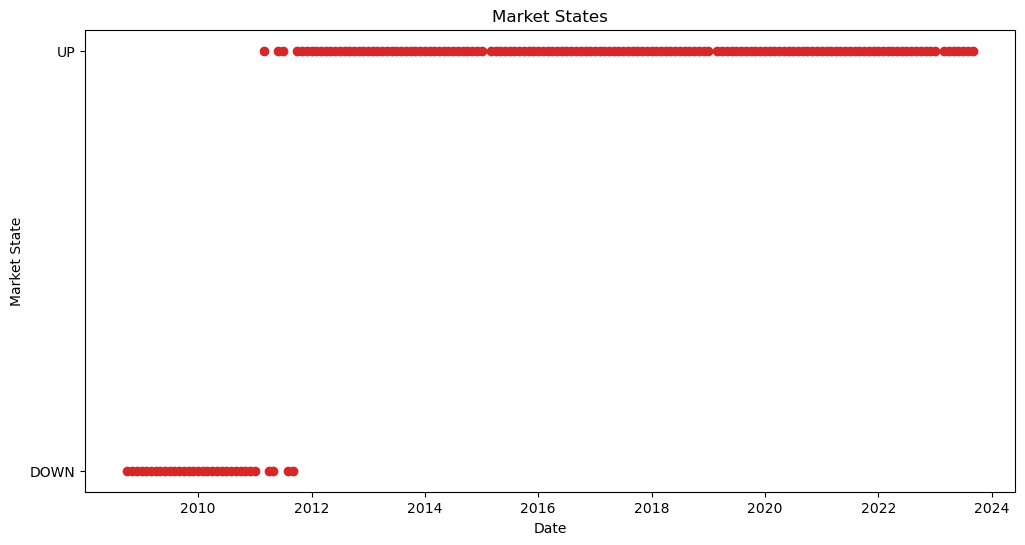

In [456]:
# Plotting when UP and DOWN states occur
# Plot the market states
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(combined_returns.index.to_timestamp(), combined_returns['UP_Dummy'],'o' ,color='tab:red')
ax.set_title('Market States')
ax.set_xlabel('Date')
ax.set_ylabel('Market State')
ax.set_yticks([0, 1])
ax.set_yticklabels(['DOWN', 'UP'])
plt.show()


# Kent Danielsen Market Stress 

### Monthly

In [447]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm

# Placeholder for downloading and reading the dataset
momentum_returns = pd.read_csv('momentum.csv')
momentum_returns['Date'] = pd.to_datetime(momentum_returns['Date'], format='%Y%m')
momentum_returns['Date'] = momentum_returns['Date'].dt.to_period('M')
momentum_returns.set_index('Date', inplace=True)
momentum_returns['Mom'] = momentum_returns['Mom'] # Convert to percentages


# Define the function to download and process monthly S&P 500 data
def download_sp500_monthly_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
    # Adjust for month-end data
    sp500_monthly = sp500['Adj Close'].resample('M').last()
    return sp500_monthly

# Define the function to calculate bear market indicator
def calculate_bear_market_indicator(sp500_data):
    bear_market_indicator = {}
    for date in sp500_data.index:
        # Look back 24 months from the current date
        lookback_date = date - pd.DateOffset(months=24)
        if lookback_date in sp500_data.index:
            past_return = sp500_data[date] / sp500_data[lookback_date] - 1
            bear_market_indicator[date] = 1 if past_return < 0 else 0
    return bear_market_indicator

# Define the function to calculate rolling variance of the S&P 500 daily returns
def calculate_market_variance(sp500_daily_data, window=126):
    daily_returns = sp500_daily_data.pct_change() * 100 * 12 # getting in percentage and monthly
    # Calculate rolling variance with the specified window size
    rolling_variance = daily_returns.rolling(window=window, min_periods=1).var()
    monthly_variance = rolling_variance.resample('B').last()
    monthly_variance = monthly_variance.resample('M').last()
    return monthly_variance

# Download S&P 500 daily data for variance calculation
sp500_daily_data = yf.download('^GSPC', start='1992-01-01', end=datetime.now().strftime('%Y-%m-%d'), interval='1d')

# Calculate bear market indicator
sp500_monthly_data = download_sp500_monthly_data('1992-01-01', datetime.now()) 
bear_market_indicator = calculate_bear_market_indicator(sp500_monthly_data)  
bear_market_indicator_df = pd.DataFrame(list(bear_market_indicator.items()), columns=['Date', 'Bear_Market_Indicator'])
bear_market_indicator_df['Date'] = pd.to_datetime(bear_market_indicator_df['Date'].dt.strftime('%Y-%m'))
bear_market_indicator_df['Date'] = bear_market_indicator_df['Date'].dt.to_period('M')
bear_market_indicator_df.set_index('Date', inplace=True)

# Calculate rolling variance of the market over the 126 days prior to each month-end
market_variance = calculate_market_variance(sp500_daily_data) # make only YearMonth index and drop nas
#make only Date index column and only make it YearMonth and then new index
market_variance['Date'] = market_variance.index
market_variance['Date'] = market_variance['Date'].dt.to_period('M')
market_variance.set_index('Date', inplace=True)
market_variance = market_variance.dropna()
market_variance = market_variance['Adj Close'].rename('market_variance')
market_variance = market_variance.to_frame()#make dataframe 


# Now we perform the regression based on the formula provided
def perform_regression(returns, bear_market_indicator, market_variance):
    # Merge the required data
    combined_data = pd.merge(returns, bear_market_indicator, on='Date')
    combined_data = pd.merge(combined_data, market_variance, left_on='Date', right_index=True)

    # Regression formula: RWML = gamma_0 + gamma_B * I_B + gamma_sigma^2 * market_variance
    # I_B is the bear market indicator, market_variance is the variance of the daily returns of the market over the 126 days prior to time t
    combined_data['Interaction_Term'] = combined_data['Bear_Market_Indicator'] * combined_data['market_variance']
    
    # Prepare the independent variables without an intercept
    X = combined_data[['Bear_Market_Indicator', 'market_variance', 'Interaction_Term']]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    Y = combined_data['Mom']
    
    model = sm.OLS(Y, X).fit()

    return model.summary()

# Example call to the regression function
regression_results = perform_regression(momentum_returns, bear_market_indicator_df, market_variance)
print(regression_results)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                    Mom   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.699
Date:                Sat, 25 Nov 2023   Prob (F-statistic):             0.0457
Time:                        02:59:25   Log-Likelihood:                -1046.7
No. Observations:                 349   AIC:                             2101.
Df Residuals:                     345   BIC:                             2117.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [

In [419]:

# Merge the bear_market_indicator and market_variance into the momentum_returns DataFrame
combined_data = pd.merge(momentum_returns, bear_market_indicator_df, on='Date')
combined_data = pd.merge(combined_data, market_variance, left_on='Date', right_index=True)

# Create interaction term for bear market and market variance
combined_data['Interaction_Term'] = combined_data['Bear_Market_Indicator'] * combined_data['market_variance']

# Define the dependent variable
Y = combined_data['Mom']

# Define multiple models with different sets of independent variables
models = {
    'model_1': ['market_variance'],
    'model_2': ['market_variance', 'Bear_Market_Indicator'],
    'model_3': ['market_variance', 'Bear_Market_Indicator', 'Interaction_Term'],
}

# Run each regression and store the results
regression_results = {}
for model_name, independent_vars in models.items():
    X = sm.add_constant(combined_data[independent_vars])  # add a constant (intercept) to the model
    model = sm.OLS(Y, X).fit()
    regression_results[model_name] = model

# Print the summary of regression results for each model
for model_name, model in regression_results.items():
    print(f"Results for {model_name}:")
    print(model.summary())
    print("\n\n")


Results for model_1:
                            OLS Regression Results                            
Dep. Variable:                    Mom   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.526
Date:                Sat, 25 Nov 2023   Prob (F-statistic):             0.0193
Time:                        02:30:03   Log-Likelihood:                 559.18
No. Observations:                 349   AIC:                            -1114.
Df Residuals:                     347   BIC:                            -1107.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0

In [424]:
# count number of 0 and 1
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

# Set the date range for the data you want to download
start = datetime(2000, 1, 1)
end = datetime.now()

# Use yfinance to download the S&P 500 data
sp500_data = yf.download('^GSPC', start=start, end=end)

# Calculate the daily returns as the percentage change in the 'Adj Close' price
sp500_data['Daily Returns'] = sp500_data['Adj Close'].pct_change()

# Calculate the variance of the daily returns
variance = sp500_data['Daily Returns'].var()

print(f"The variance of daily returns for the S&P 500 index is {variance}")


[*********************100%%**********************]  1 of 1 completed
The variance of daily returns for the S&P 500 index is 0.00015325018803593227


### Daily

In [448]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm

# Download S&P 500 daily data
sp500_daily_data = yf.download('^GSPC', start='1952-01-01', end=datetime.now().strftime('%Y-%m-%d'), interval='1d')

# Define the function to calculate bear market indicator on a daily basis
def calculate_bear_market_indicator_daily(sp500_data, window=24*21):  # 24 months approximately in trading days
    bear_market_indicator = (sp500_data['Adj Close'].rolling(window).apply(lambda x: np.where(x.iloc[-1] < x.iloc[0], 1, 0)))[window:]
    return bear_market_indicator

# Define the function to calculate rolling variance of the S&P 500 daily returns
def calculate_market_variance_daily(sp500_daily_data, window=126):
    daily_returns = sp500_daily_data['Adj Close'].pct_change() * 100
    rolling_variance = daily_returns.rolling(window=window, min_periods=1).var()
    return rolling_variance

# Calculate bear market indicator on a daily basis
bear_market_indicator_daily = calculate_bear_market_indicator_daily(sp500_daily_data)

# Calculate rolling variance of the market on a daily basis
market_variance_daily = calculate_market_variance_daily(sp500_daily_data)

# Placeholder for downloading and reading the daily momentum dataset
# Ensure that momentum_returns is a daily dataset with a 'Mom' column
data_momentum = pd.read_csv('momentum.csv', index_col=0)
data_momentum.index = data_momentum.index.astype(int)
# last daily momemdata from /Users/anderssteiness/Desktop/MIT/CapMar/F-F_Momentum_Factor_daily.CSV 
data_momentum_daily = pd.read_csv('F-F_Momentum_Factor_daily.CSV', index_col=0)[:-1]
#Make date format for data_momentum_daily index change from YYYYMMDD to YYYY-MM-DD
data_momentum_daily.index = pd.to_datetime(data_momentum_daily.index, format='%Y%m%d')
data_momentum_daily = data_momentum_daily.rename(columns={'Mom   ': 'Mom'})

# Now we perform the regression based on the formula provided
def perform_daily_regression(returns, bear_market_indicator, market_variance):
    # Combine the data
    combined_data = pd.concat([returns, bear_market_indicator.rename('Bear_Market_Indicator'), market_variance.rename('market_variance')], axis=1).dropna()
    
    # Create interaction term
    combined_data['Interaction_Term'] = combined_data['Bear_Market_Indicator'] * combined_data['market_variance']
    
    # Prepare the independent variables with a constant term
    X = combined_data[['Bear_Market_Indicator', 'market_variance', 'Interaction_Term']]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    Y = combined_data['Mom']
    model = sm.OLS(Y, X).fit()

    return model.summary()

# Perform the regression
regression_results = perform_daily_regression(data_momentum_daily, bear_market_indicator_daily, market_variance_daily)
print(regression_results)


[*********************100%%**********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                    Mom   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     20.11
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           5.23e-13
Time:                        02:59:47   Log-Likelihood:                -19472.
No. Observations:               17554   AIC:                         3.895e+04
Df Residuals:                   17550   BIC:                         3.898e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [446]:
data_momentum_daily

,Mom
1926-11-03,0.56
1926-11-04,-0.50
1926-11-05,1.17
1926-11-06,-0.03
1926-11-08,-0.01
...,...
2023-09-25,0.13
2023-09-26,0.39
2023-09-27,1.16
2023-09-28,0.27


In [449]:
# Merge the bear_market_indicator and market_variance into the momentum_returns DataFrame
combined_data = pd.concat([data_momentum_daily, bear_market_indicator_daily.rename('Bear_Market_Indicator'), market_variance_daily.rename('market_variance')], axis=1).dropna()

# Create interaction term for bear market and market variance
combined_data['Interaction_Term'] = combined_data['Bear_Market_Indicator'] * combined_data['market_variance']

# Define the dependent variable
Y = combined_data['Mom']

# Define multiple models with different sets of independent variables
models = {
    'model_1': ['market_variance'],
    'model_2': ['market_variance', 'Bear_Market_Indicator'],
    'model_3': ['market_variance', 'Bear_Market_Indicator', 'Interaction_Term'],
}

# Run each regression and store the results
regression_results = {}
for model_name, independent_vars in models.items():
    X = sm.add_constant(combined_data[independent_vars])  # add a constant (intercept) to the model
    model = sm.OLS(Y, X).fit()
    regression_results[model_name] = model

# Print the summary of regression results for each model
for model_name, model in regression_results.items():
    print(f"Results for {model_name}:")
    print(model.summary())
    print("\n\n")


Results for model_1:
                            OLS Regression Results                            
Dep. Variable:                    Mom   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     53.81
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           2.30e-13
Time:                        02:59:50   Log-Likelihood:                -19476.
No. Observations:               17554   AIC:                         3.896e+04
Df Residuals:                   17552   BIC:                         3.897e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0

In [435]:
combined_data = pd.concat([data_momentum_daily, bear_market_indicator_daily.rename('Bear_Market_Indicator'), market_variance_daily.rename('market_variance')], axis=1).dropna()
combined_data

,Mom,Bear_Market_Indicator,market_variance
1954-01-07,0.45,0.0,0.000030
1954-01-08,0.14,0.0,0.000030
1954-01-11,0.20,0.0,0.000030
1954-01-12,-0.19,0.0,0.000030
1954-01-13,-0.28,0.0,0.000031
...,...,...,...
2023-09-25,0.13,1.0,0.000052
2023-09-26,0.39,1.0,0.000054
2023-09-27,1.16,1.0,0.000054
2023-09-28,0.27,1.0,0.000053


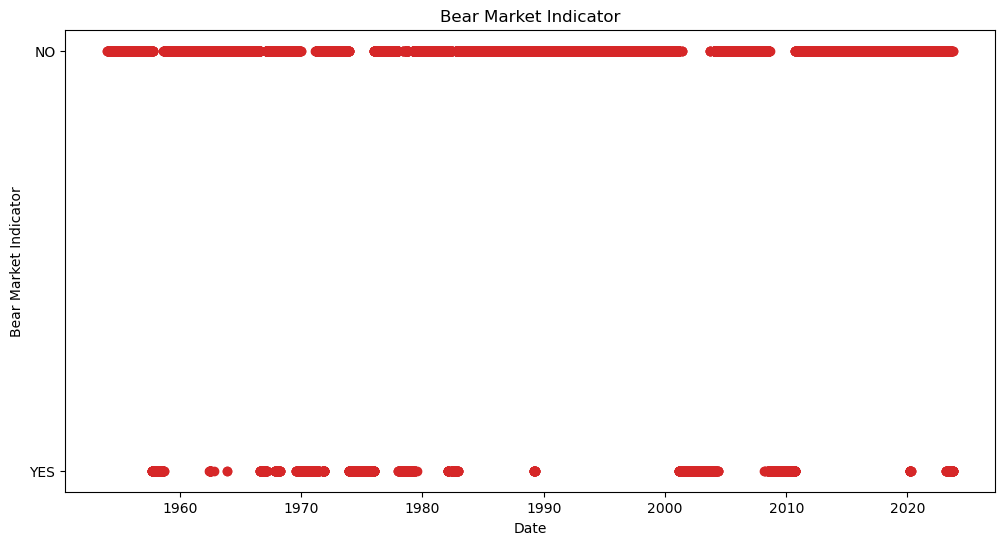

In [461]:
# Plot bear market indicator as dots
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(combined_data.index, 1 - combined_data['Bear_Market_Indicator'], 'o', color='tab:red')   
ax.set_title('Bear Market Indicator')
ax.set_xlabel('Date')
ax.set_ylabel('Bear Market Indicator')
ax.set_yticks([0, 1])
ax.set_yticklabels(['YES', 'NO']) 
plt.show()


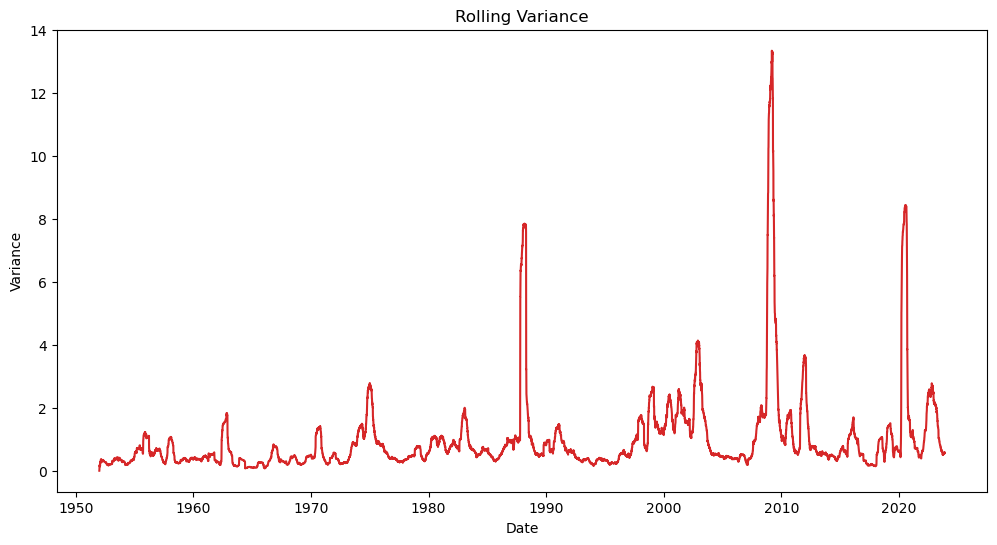

In [462]:
# Plotting 126 days rolling variance
# Plot the rolling variance
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(market_variance_daily.index, market_variance_daily, color='tab:red')
ax.set_title('Rolling Variance')
ax.set_xlabel('Date')
ax.set_ylabel('Variance')
plt.show()


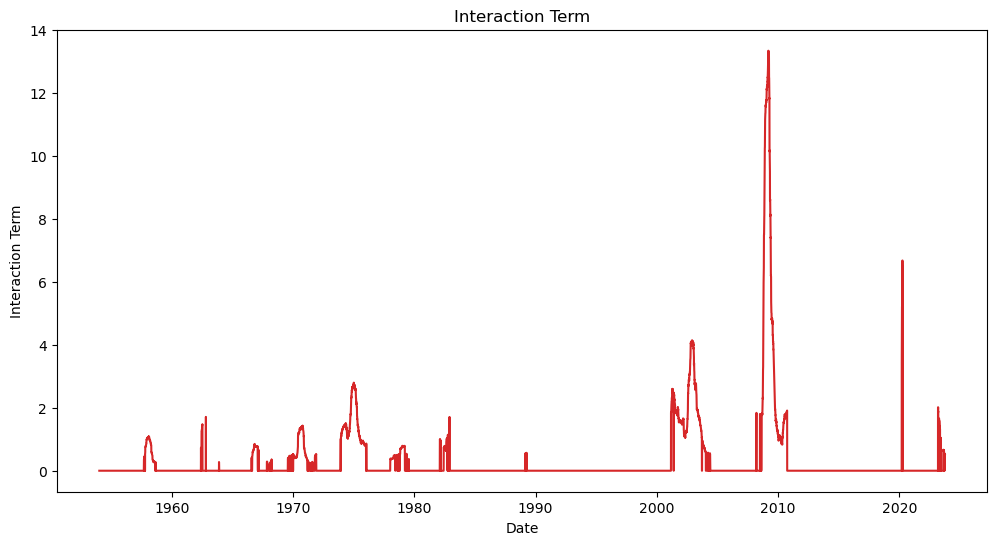

In [463]:
# Plot the interaction term
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(combined_data.index, combined_data['Interaction_Term'], color='tab:red')
ax.set_title('Interaction Term')
ax.set_xlabel('Date')
ax.set_ylabel('Interaction Term')
plt.show()


# Financial Turbulance

In [472]:
# Import data
file = "turbulence.csv"
df = pd.read_csv(file) # This is Monthly turbulance data
df = df.rename(columns={'Unnamed: 0': 'Date'})# Change name of column 'Unnamed: 0' to 'Date'
print(df)

       Date       d_t
0    199309  0.891057
1    199310  0.033597
2    199311  6.081134
3    199312  2.382803
4    199401  7.370327
..      ...       ...
356  202305  2.766112
357  202306  3.068864
358  202307  2.228960
359  202308  2.549220
360  202309  3.196540

[361 rows x 2 columns]


In [471]:
#Daily Turbulence data
file = "turbulence_daily.csv"
df_daily = pd.read_csv(file) # This is Monthly turbulance data
print(df_daily)

      Daily Turbulance       Date
0             7.594085   7/2/1990
1             6.743464   7/3/1990
2             7.529389   7/5/1990
3             7.026809   7/6/1990
4             6.767855   7/9/1990
...                ...        ...
8371          2.829887  9/25/2023
8372          3.515642  9/26/2023
8373          2.116642  9/27/2023
8374          2.179891  9/28/2023
8375          1.849151  9/29/2023

[8376 rows x 2 columns]
